In [2]:
!pip install scikit-plot

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [6]:
import pandas as pd
import numpy as np


import os

# Plotting
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns

# Prediction
import nltk
import re
import itertools


# Classifiers
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier
from sklearn.dummy import DummyClassifier # Validation
import scikitplot as skplt #to make things easy
# packages to import

import pylab as pl
from sklearn import svm
from sklearn.utils import shuffle
from sklearn.metrics import roc_curve, auc
random_state = np.random.RandomState(0)



from sklearn.naive_bayes import GaussianNB
from sklearn.svm import LinearSVC
from sklearn import svm
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LinearRegression, LogisticRegression, SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.model_selection import cross_val_score
# Data prepping
from sklearn.preprocessing import LabelEncoder

print("Libraries imported.")
from sklearn.dummy import DummyClassifier # Validation
from sklearn.model_selection import train_test_split
from sklearn import model_selection, tree, preprocessing, metrics, linear_model
import math, time, random, datetime
pd.set_option('display.max_columns', 50)

from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report, confusion_matrix

Libraries imported.


In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [7]:
HOME_DIR = os.curdir if os.name == 'nt' else "/content/drive/MyDrive"
DATA_DIR = os.path.join(HOME_DIR, 'data' if os.name == 'nt' else  "CA683Data") 

In [8]:
os.listdir(DATA_DIR)

['globalterrorismdb_0718dist 2.csv', 'terrorist_weather_jan2012_dec_2016.csv']

In [9]:
#Importing the Dataset
data = pd.read_csv(os.path.join(DATA_DIR, "globalterrorismdb_0718dist 2.csv"), encoding="ISO-8859-1")

<ipython-input-9-3aa5dbf9bdfd>:2: DtypeWarning: Columns (4,6,31,33,61,62,63,76,79,90,92,94,96,114,115,121) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv(os.path.join(DATA_DIR, "globalterrorismdb_0718dist 2.csv"), encoding="ISO-8859-1")


In [10]:
data_columns = [
    
    'eventid', # Unique ID for a row. No analytic or predictive power, but used in some plotting functions.
    
    # ===== Spatio-Temporal Variables =====
    # The names of these variables speak for themselves;
    # where in time and space was the act of terrorism committed?
                'iyear', 'imonth', 'iday', 'latitude', 'longitude',
    
    # ===== Binary Variables (1 -> yes or 0 -> no) ===== 
                'extended', # Did the duration of the incident extend 24 hours?
                'vicinity', # Did the incident occur in the immediate vicinity of the city? Is 0 for IN city.
                'crit1', 'crit2', 'crit3', # The incident meets the criterion (1, 2, 3), described in the introduction.
                'doubtterr', # Is there doubt to wether the attack is an act of terrorism?
                'multiple', # Is this incident connected to other incident(s)? !! Consistently available since 1997 !!
                'success', # Has the attack reached its goal? Depends on type of attack.
                'suicide', # Did the perpetrator intend to escape alive?
                'claimed', # Was the attack claimed by an organised group?
                'property', # Is there evidence of property damage from the incident?
                'ishostkid', # Were there victims taken hostage or kidnapped?
    
    # ===== Continuous Variables =====
                'nkill', # Amount of confirmed kills.
                'nwound', # Amount of confirmed wounded.
    # ===== Categorical variables =====
                'country_txt', # Name of country.
                'region', # Region id.
                'region_txt', # Name of region.
                'attacktype1_txt', # Of what type was the attack? I.e. assassination, bombing or kidnapping.
                'targtype1_txt', # What target did the attack have? I.e. business, government or police.
                'natlty1_txt', # Nationality of the target.
                'weaptype1_txt', # What weapon was used?
    
    # ===== Descriptive Variables =====
                'target1', # Description of specific target, if applicable.
                'gname', # Name of the organized group, if applicable.
                'summary', # Summary of the attack.
    
]

In [11]:
#Cleaning the data
data = data.loc[:, data_columns] # Only keep described columns.

# Random acts of violence and other outliers should not be part of the data.
# Thus, restrict the set the only attacks where the terrorism motive is certain.
data = data[(data.crit1 == 1) & (data.crit2 == 1) & (data.crit3 == 1) & (data.doubtterr == 0)]

# Weapontype column contains very long name for vehicle property -> shorten.
data.weaptype1_txt.replace(
    'Vehicle (not to include vehicle-borne explosives, i.e., car or truck bombs)',
    'Vehicle', inplace = True)

# Replace -9 (unknown) values with 0 (no). -9 values are much more likely to be false than true.
data.iloc[:,[6, 15, 16, 17]] = data.iloc[:,[6, 15, 16, 17]].replace(-9,0)

# Some values in the claimed category are 2 (should be 0 or 1).
# Assume these were input mistakes and set 2 to 1.
data.claimed.replace(2,1, inplace = True)

# Ensure consistent values and make everything lowercase.
data.target1 = data.target1.str.lower()
data.gname = data.gname.str.lower()
data.summary = data.summary.str.lower()    
data.target1 = data.target1.fillna('unknown').replace('unk','unknown')

# Some nwound and nkill are NaN. Replace them with median.
data.nkill = np.round(data.nkill.fillna(data.nkill.median())).astype(int) 
data.nwound = np.round(data.nwound.fillna(data.nwound.median())).astype(int) 

# Database only reports victims as nkill and nwound. Combine these into ncasualties column.
# Also add has_casualties column.
data['ncasualties'] = data['nkill'] + data['nwound']
data['has_casualties'] = data['ncasualties'].apply(lambda x: 0 if x == 0 else 1)

print("Data cleaned and prepared.")

Data cleaned and prepared.


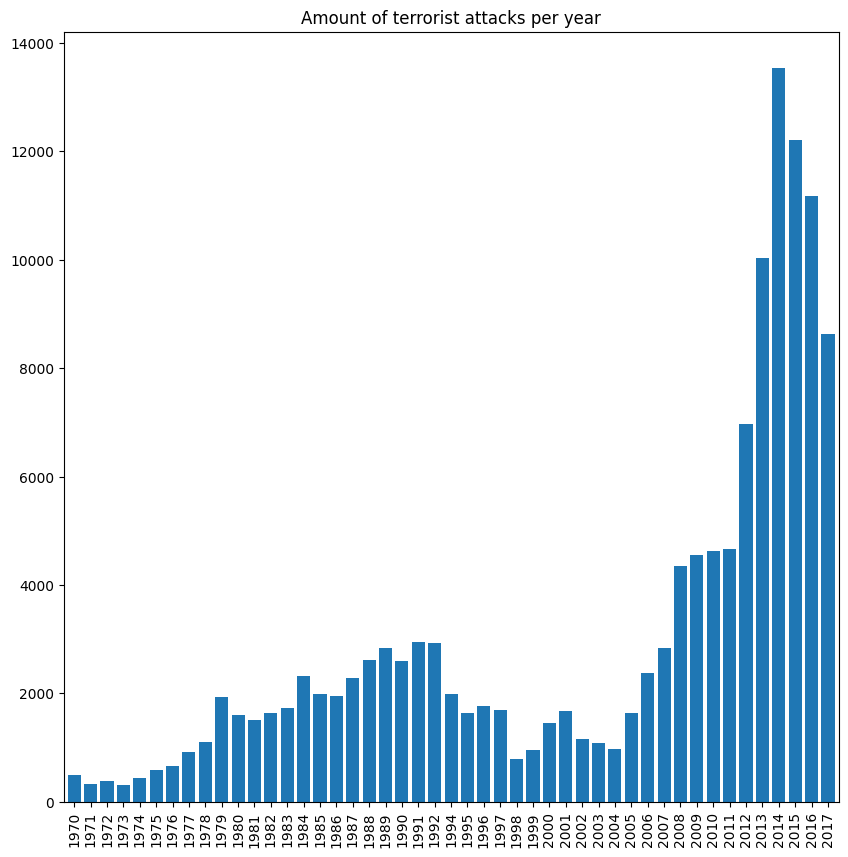

In [12]:
# Data exploration
barplot = pd.value_counts(data['iyear'])\
.sort_index()\
.plot\
.bar(width=0.8, figsize=(10, 10), title="Amount of terrorist attacks per year")

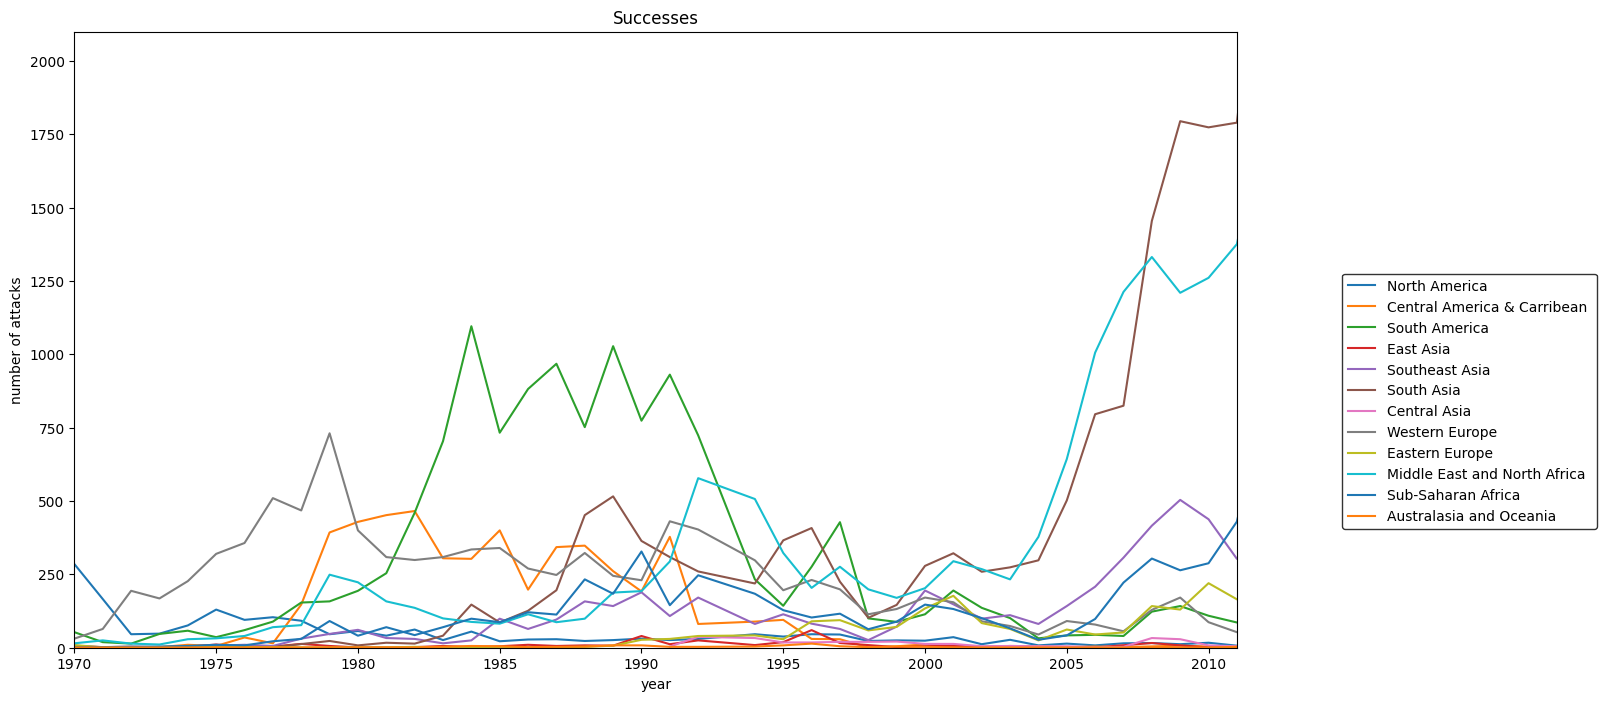

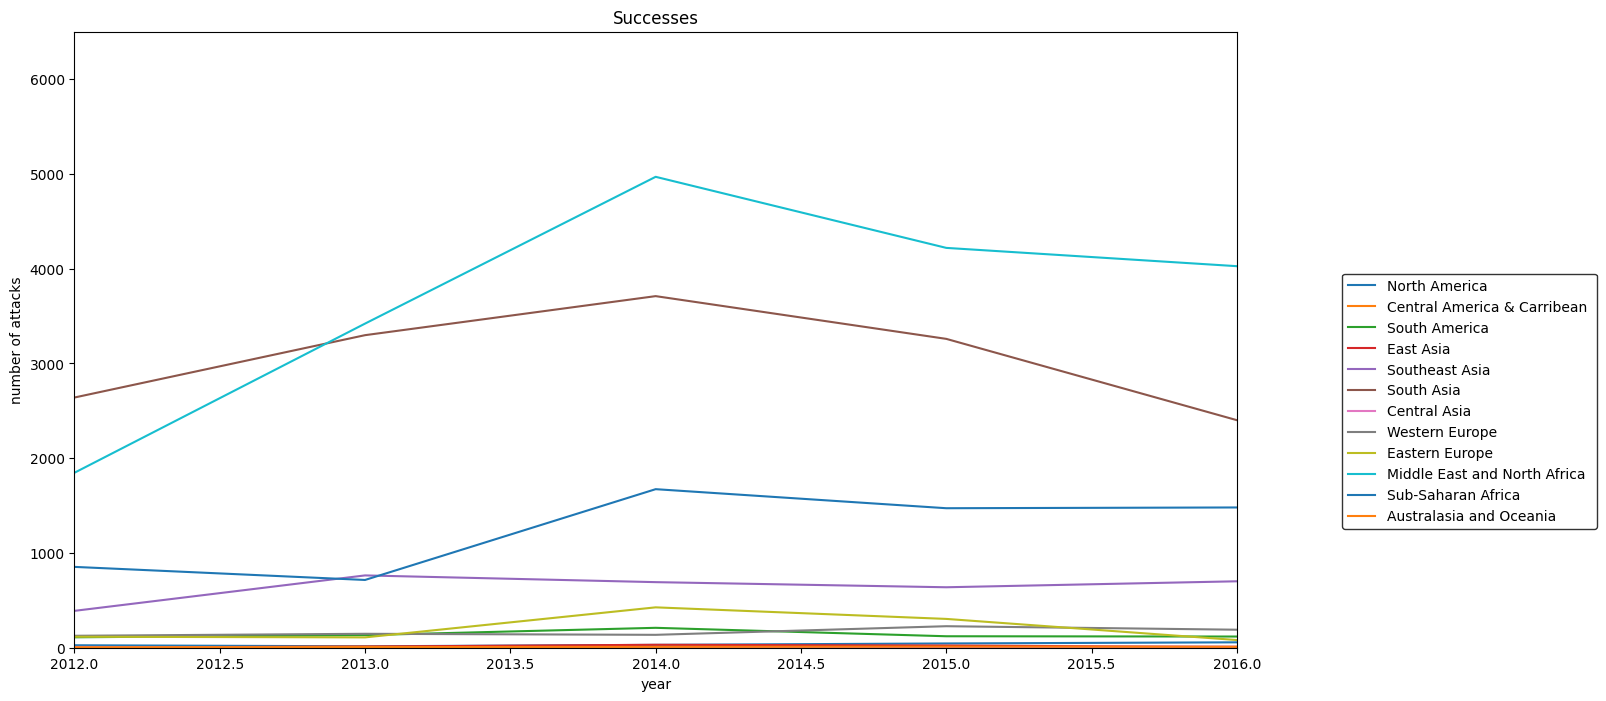

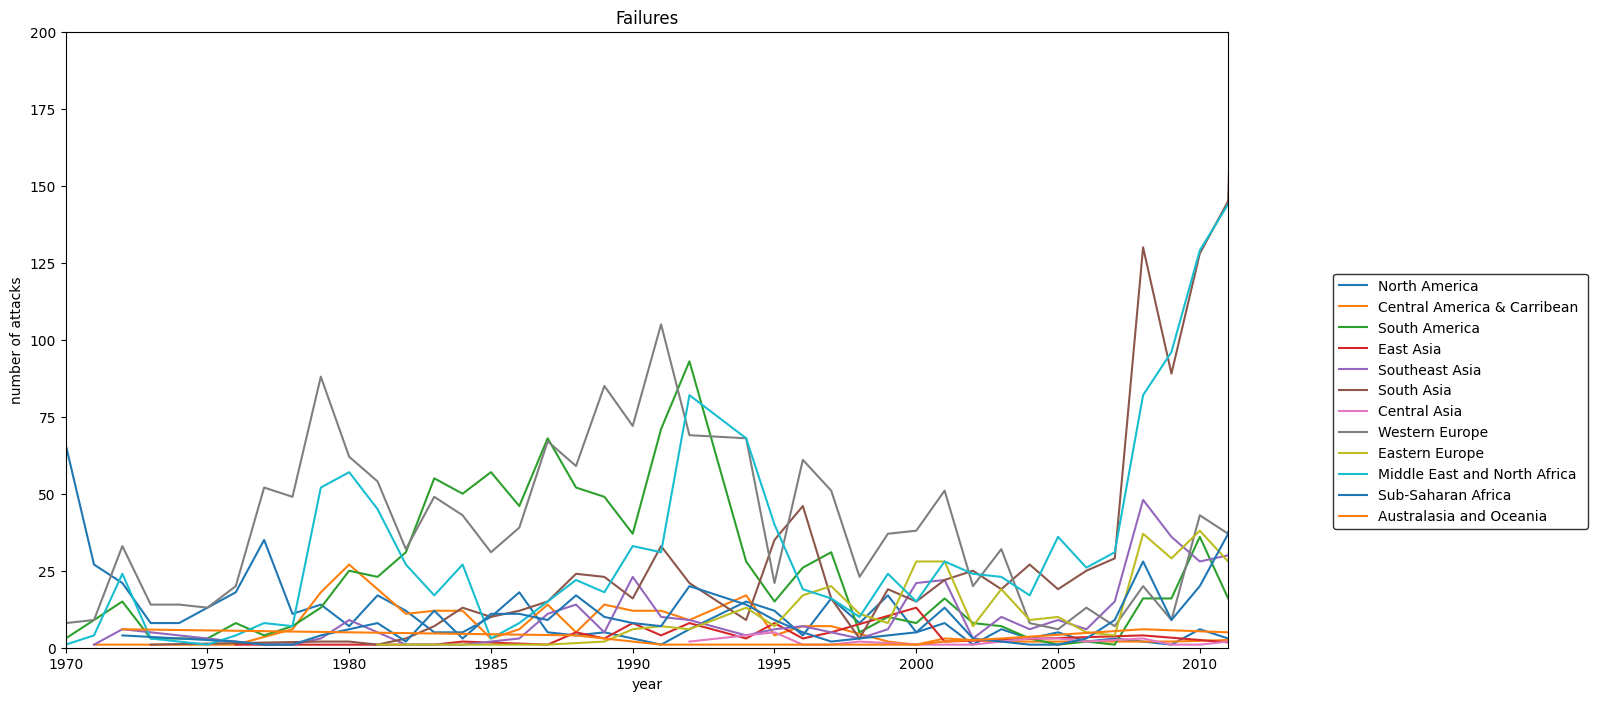

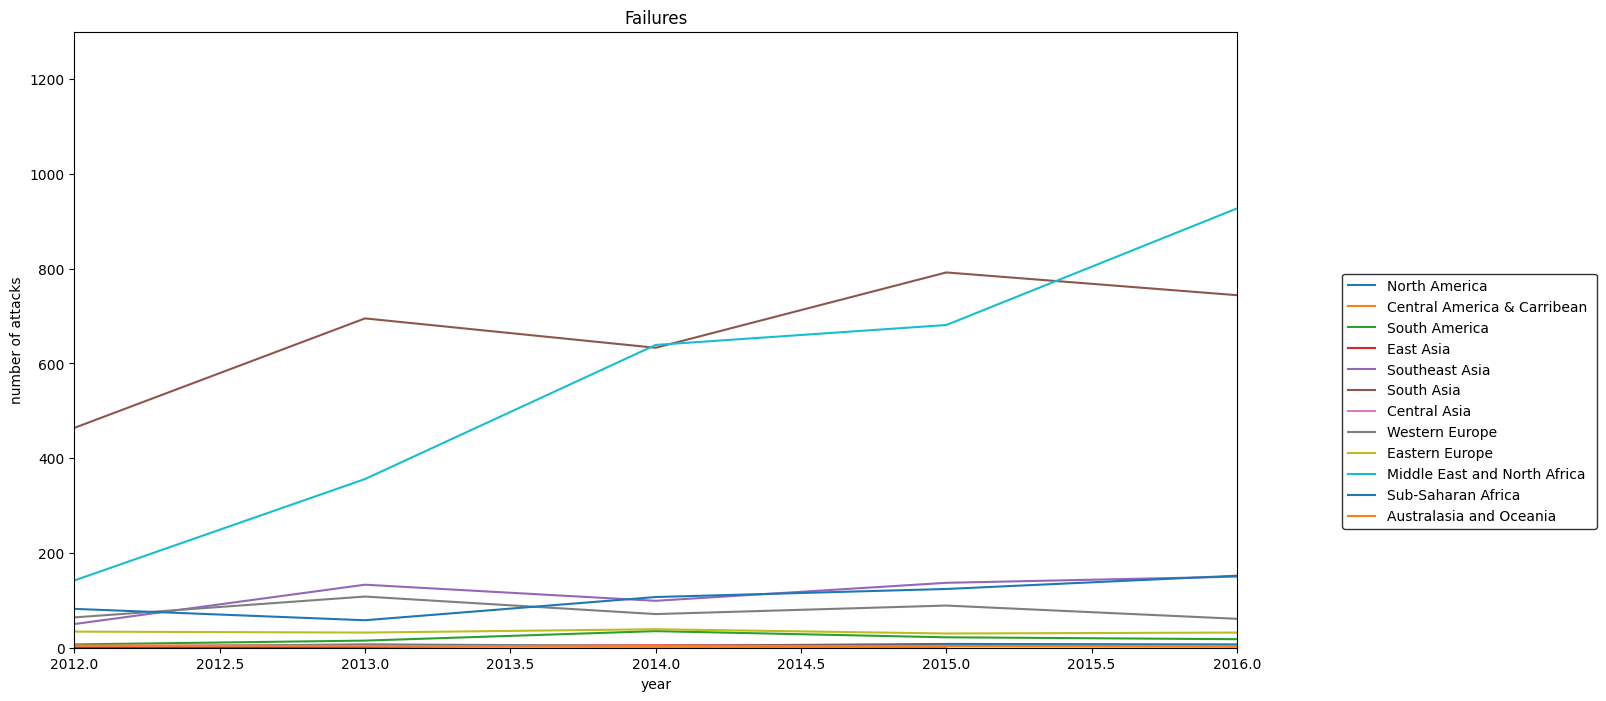

In [13]:
region_dictionary = {1: 'North America', 2: 'Central America & Carribean', 3: 'South America',
                     4: 'East Asia', 5: 'Southeast Asia', 6: 'South Asia', 7: 'Central Asia',
                     8: 'Western Europe', 9: 'Eastern Europe', 10: 'Middle East and North Africa',
                     11: 'Sub-Saharan Africa', 12: 'Australasia and Oceania'}

def multi_graph(result,result_list, xmin, xmax, ymin, ymax):
    fig2, ax2 = plt.subplots(figsize = (15,8))
    number = 1 #the for-loop in append_list processes the regions in order from 1 to 12
    for j in result_list:
        ax2.plot(j.index, j.eventid, label = '%s ' % region_dictionary[number] )
        number += 1

    plt.xlim([xmin,xmax])
    plt.ylim([ymin,ymax])
    plt.xlabel('year')
    plt.ylabel('number of attacks')
    plt.title(result)
    ax2.legend(loc = 'center', frameon = True, edgecolor = 'black',bbox_to_anchor =(1.2,0.4))


success_list = []
failure_list = []

for i in region_dictionary:
    region_data = data[(data.region == i)]
    region_data_success = region_data[(region_data.success == 1)]
    region_data_failure = region_data[(region_data.success == 0)]
    region_grouped_success = region_data_success.groupby('iyear').count()
    region_grouped_failure = region_data_failure.groupby('iyear').count()

    
    success_list.append(region_grouped_success)
    failure_list.append(region_grouped_failure)

multi_graph('Successes',success_list, 1970, 2011, 0, 2100)
multi_graph('Successes',success_list, 2012, 2016, 0, 6500)
multi_graph('Failures',failure_list, 1970, 2011, 0, 200)
multi_graph('Failures',failure_list, 2012, 2016, 0, 1300)

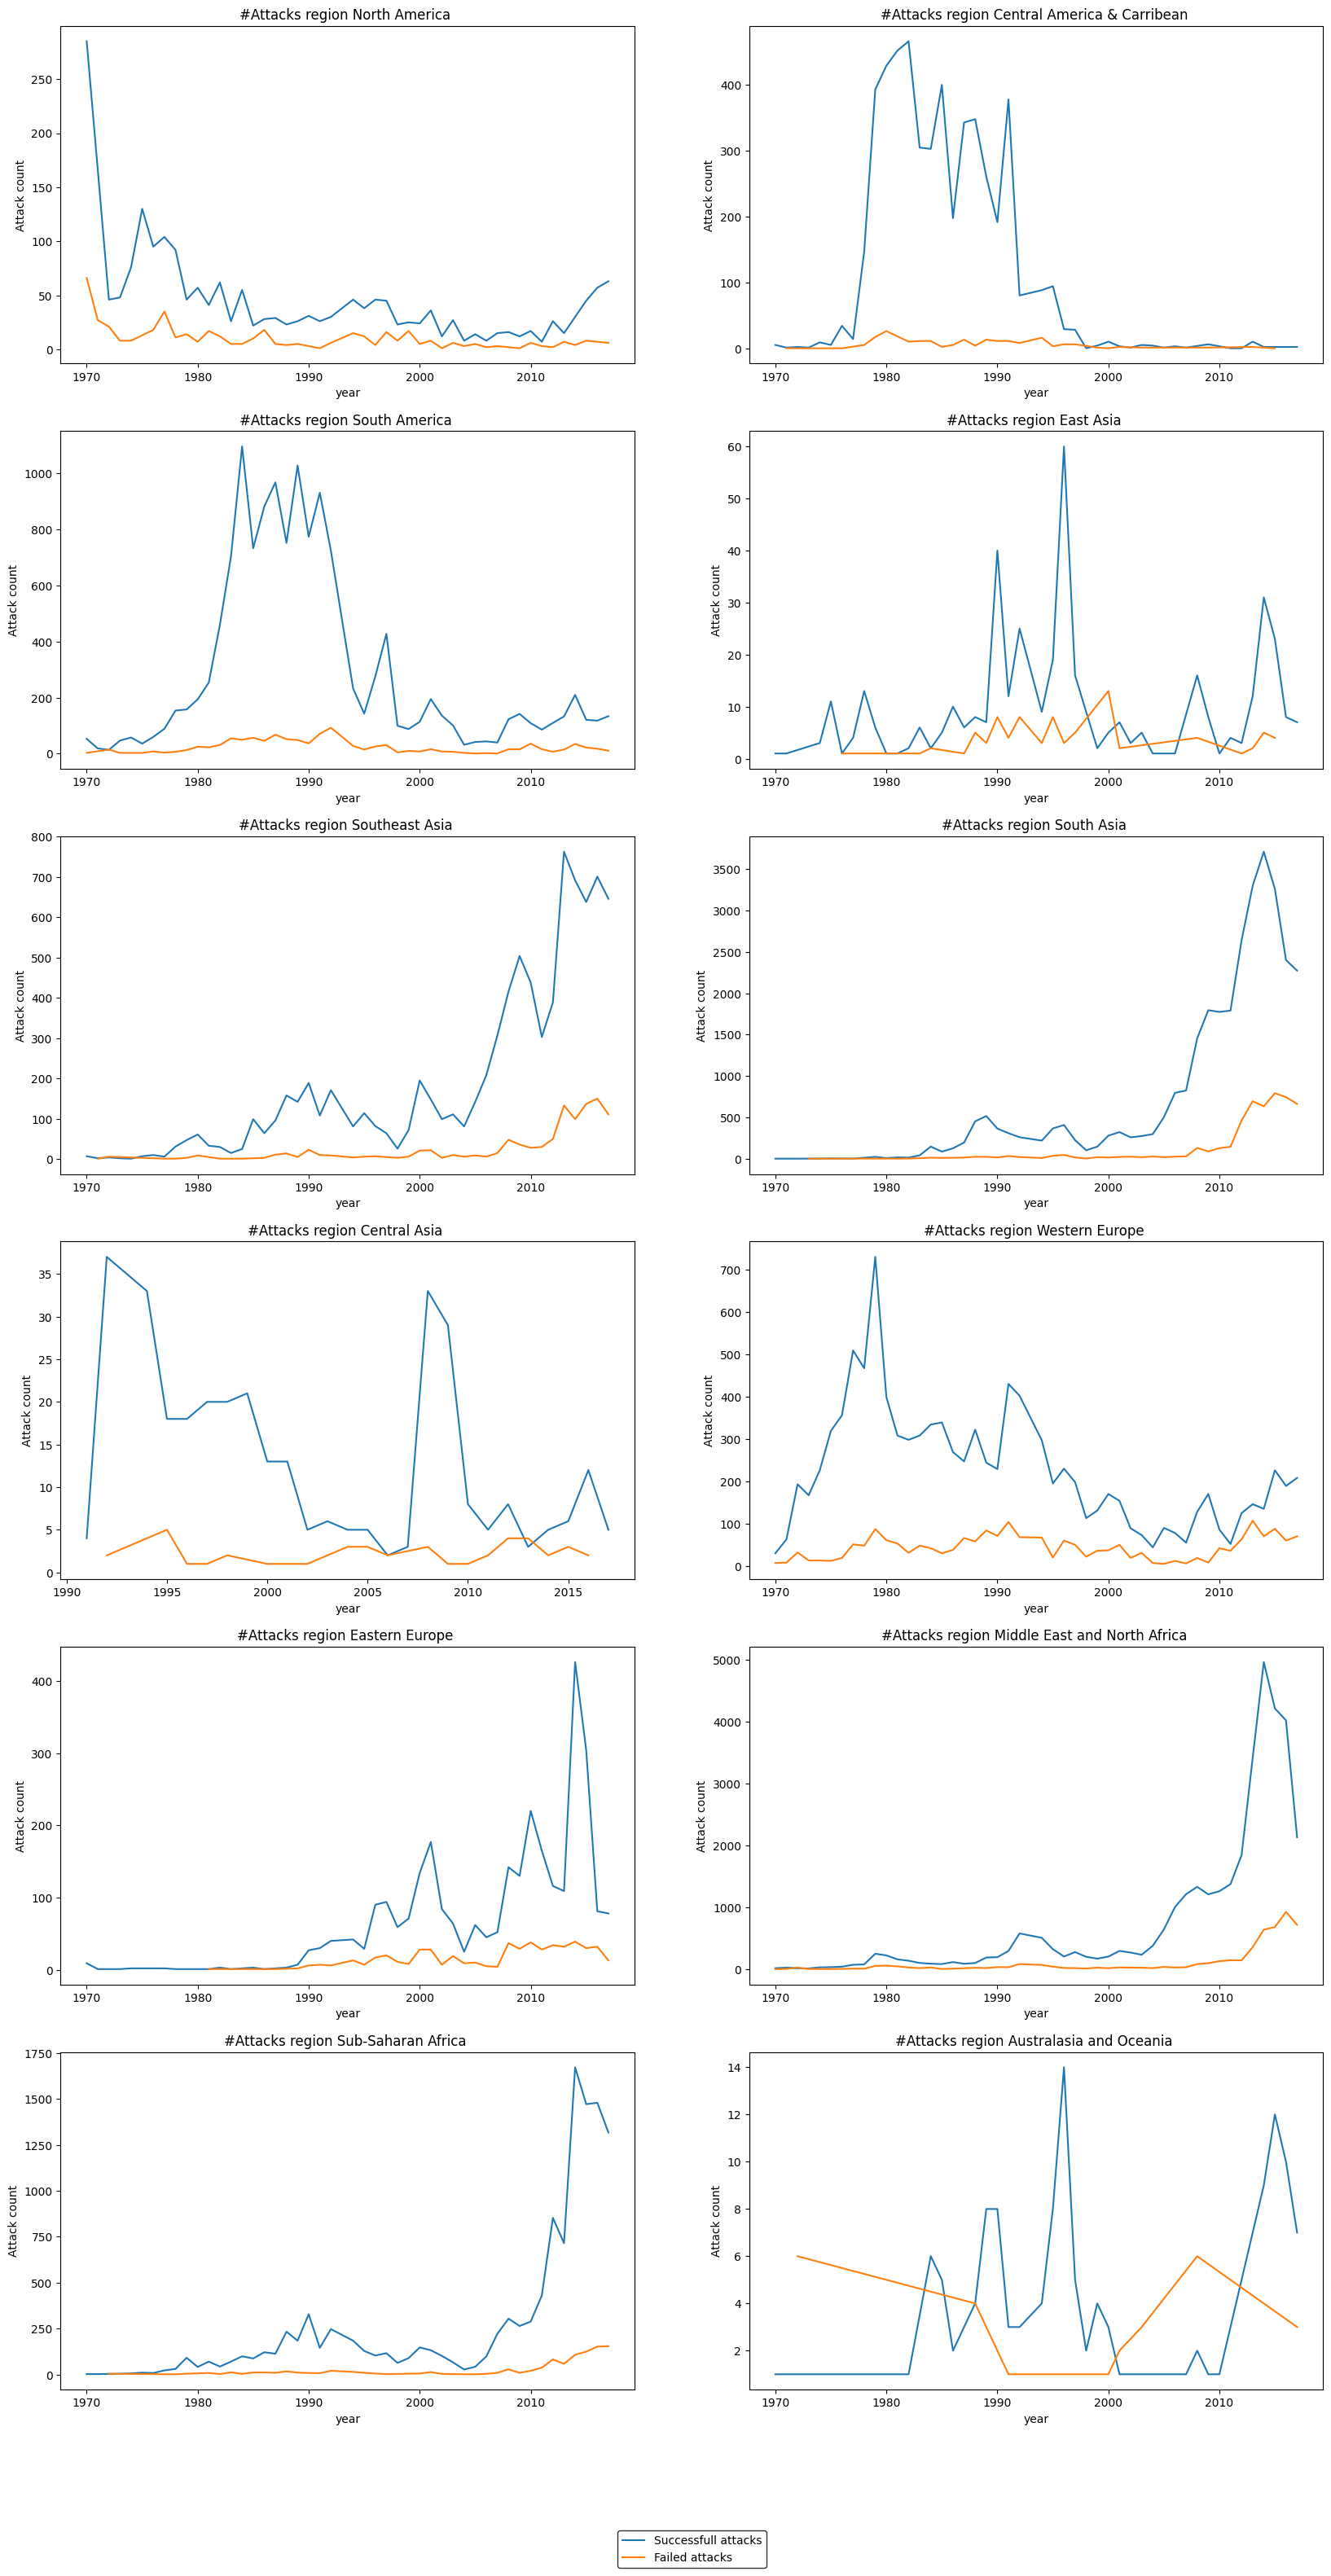

In [14]:
def generate_graph(by_region_list):
    fig = plt.figure(figsize=(20,70))
    i = 1
    
    for element in by_region_list:
        ax1 = fig.add_subplot(11,2,i)
        ax1.set(title = '#Attacks region %s ' % region_dictionary[element[2]],
                ylabel = 'Attack count', xlabel = 'year')

        #entering data
        ax1.plot(element[0].index, element[0].eventid, label = 'Successfull attacks' )
        ax1.plot(element[1].index, element[1].eventid, label = 'Failed attacks' )
        
        i+=1
    
    #add legend
    ax1.legend(loc = 'upper center', frameon = True, edgecolor = 'black', bbox_to_anchor =(-0.1,-0.4))
    plt.show()  


def by_region():
        for region_number in region_dictionary:
            region_data = data[(data.region == region_number)] #for each region group data by year
            region_grouped_success = region_data[(region_data.success == 1)].groupby('iyear').count() #filter on success and group by year
            region_grouped_failure = region_data[(region_data.success == 0)].groupby('iyear').count() #filter on failure and group by year
            
            by_region_list.append([region_grouped_success, region_grouped_failure, region_number])
        
        #create line plot for region grouped by year
        generate_graph(by_region_list)

by_region_list = []
by_region()

Text(0, 0.5, 'Attack type')

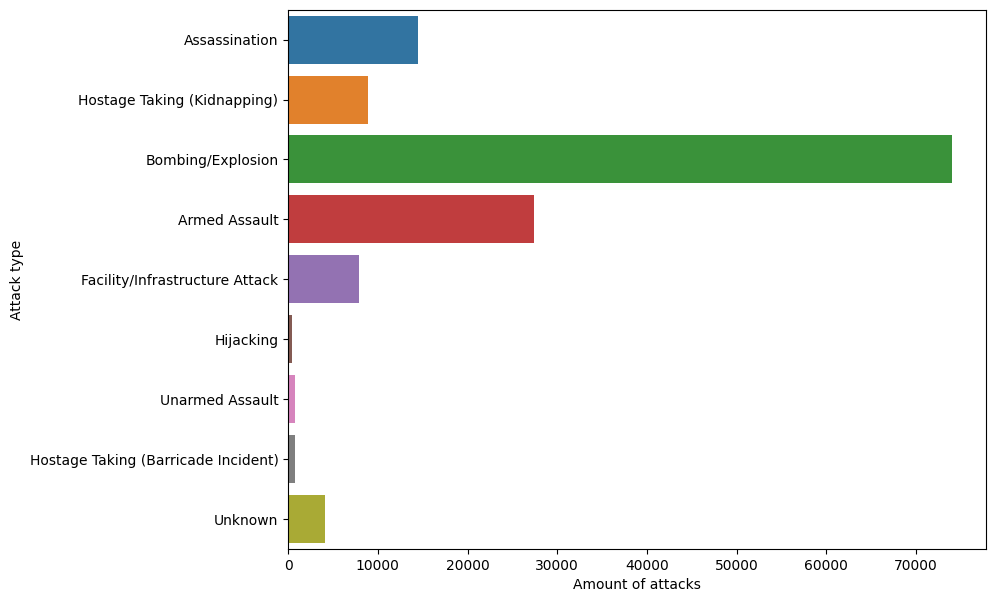

In [15]:
plt.figure(figsize=(9,7))
ax = sns.countplot(y="attacktype1_txt", data=data)
ax.set_xlabel("Amount of attacks")
ax.set_ylabel("Attack type")

In [16]:
# Load the dataset.
data_w = pd.read_csv(os.path.join(DATA_DIR, "terrorist_weather_jan2012_dec_2016.csv"), encoding="ISO-8859-1")

In [17]:
# This set has the same columns as the original dataset and has been cleaned in the same manner.
# Additionally, five weather condition columns were added, as described above.
data_w.head()

iyear  imonth  iday   latitude  longitude  extended  vicinity  crit1  \
0   2012       1     1  30.209423  67.018009         0         0      1   
1   2012       1     1  -0.456120  39.646123         0         0      1   
2   2012       1     1  -0.456120  39.646123         0         0      1   
3   2012       1     1  28.466667  67.283333         1         0      1   
4   2012       1     1  34.761723  71.324719         0         0      1   

   crit2  crit3  doubtterr  multiple  success  suicide  claimed  property  \
0      1      1          0         0        1        0      0.0         1   
1      1      1          0         1        1        0      0.0         1   
2      1      1          0         1        1        0      0.0         1   
3      1      1          0         0        1        0      0.0         0   
4      1      1          0         0        1        0      0.0         1   

   ishostkid  nkill  nwound country_txt          region_txt  \
0        0.0      0      12    Pakistan          South Asia   
1        0.0      3      14       Kenya  Sub-Saharan Africa   
2        0.0      2      14       Kenya  Sub-Saharan Africa   
3        1.0      0       0    Pakistan          South Asia   
4        0.0      1       3    Pakistan          South Asia   

               attacktype1_txt                 targtype1_txt natlty1_txt  \
0            Bombing/Explosion                      Business    Pakistan   
1                Armed Assault                      Business       Kenya   
2                Armed Assault                      Business       Kenya   
3  Hostage Taking (Kidnapping)   Private Citizens & Property    Pakistan   
4            Bombing/Explosion  Terrorists/Non-State Militia    Pakistan   

               weaptype1_txt          target1       gname  \
0  Explosives/Bombs/Dynamite        paan shop     unknown   
1  Explosives/Bombs/Dynamite              bar  al-shabaab   
2  Explosives/Bombs/Dynamite              bar  al-shabaab   
3                   Firearms        civilians     unknown   
4  Explosives/Bombs/Dynamite  militia members     unknown   

                                             summary  ncasualties  \
0  01/01/2012: a grenade was thrown into a shop o...           12   
1  01/01/2012: assailants threw two grenades and ...           17   
2  01/01/2012: assailants threw a grenade and ope...           16   
3  01/01/2012: four men were kidnapped from their...            0   
4  01/01/2012: an explosive device targeting anti...            4   

   has_casualties         t2m           tcc       vidgf             sp  \
0               1  288.217098  9.998669e-13 -366.496179  101457.723797   
1               1  297.077670  1.530221e-01  606.077234  101103.215653   
2               1  297.077670  1.530221e-01  606.077234  101103.215653   
3               0  287.513173  9.998669e-13  -17.655798  100755.508624   
4               1  269.929184  9.998669e-13   62.722170   79226.577609   

        v10  
0 -3.828428  
1  1.320113  
2  1.320113  
3 -3.728933  
4  0.577216

In [18]:
# Define X and y.
X = data_w[['t2m', 'tcc', 'vidgf', 'sp', 'v10']].fillna(0) # Features
y = data_w['has_casualties'].fillna(0) # Target

X.shape, y.shape

((53715, 5), (53715,))

In [19]:
# Count the number of attacks that have at least 1 casualty and those that don't.
y.value_counts()

1    36396
0    17319
Name: has_casualties, dtype: int64

In [20]:
#Splitting the data into train and test set 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42)

In [21]:
#Predicting using Logistic Regression for Binary classification 
from sklearn.linear_model import LogisticRegression
LR = LogisticRegression()
LR.fit(X_train,y_train) #fitting the model 
y_pred = LR.predict(X_test) #prediction

Confusion matrix, without normalization
[[    0  5146]
 [    0 10969]]
Normalized confusion matrix
[[0. 1.]
 [0. 1.]]


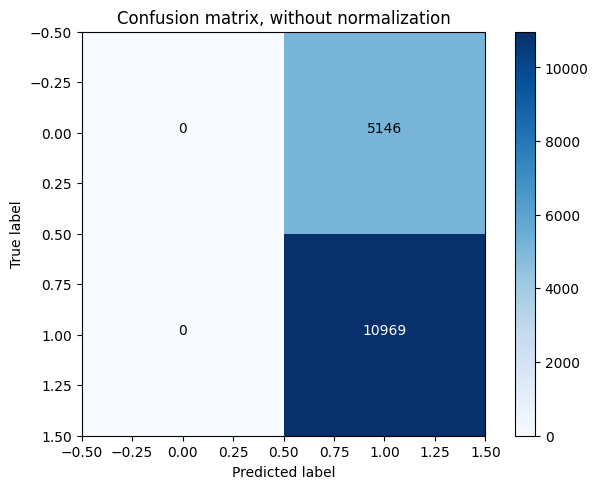

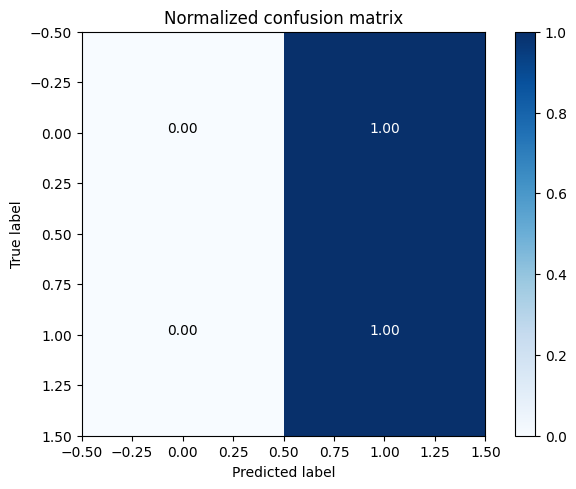

True Negatives:  0
False Positives:  5146
False Negatives:  0
True Positives:  10969
Precision 0.68
Recall 1.00
F1 Score 0.81
F2 0.91

F0.5 0.73
Specificity 0.00
Accuracy 0.68


In [22]:
cnf_matrix = confusion_matrix(y_test, y_pred)
 

def plot_confusion_matrix(cm,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')
 
    print(cm)
 
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
 
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
 
# Compute confusion matrix
np.set_printoptions(precision=2)
 
# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix,
                      title='Confusion matrix, without normalization')
 
# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, normalize=True,
                      title='Normalized confusion matrix')
 
plt.show()

#extracting true_positives, false_positives, true_negatives, false_negatives
tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
print("True Negatives: ",tn)
print("False Positives: ",fp)
print("False Negatives: ",fn)
print("True Positives: ",tp)

#Precision 
Precision = tp/(tp+fp) 
print("Precision {:0.2f}".format(Precision))

#Recall 
Recall = tp/(tp+fn) 
print("Recall {:0.2f}".format(Recall))

#F1 Score
f1 = (2*Precision*Recall)/(Precision + Recall)
print("F1 Score {:0.2f}".format(f1))

#F-beta score calculation
def fbeta(precision, recall, beta):
    return ((1+pow(beta,2))*precision*recall)/(pow(beta,2)*precision + recall)
            
f2 = fbeta(Precision, Recall, 2)
f0_5 = fbeta(Precision, Recall, 0.5)

print("F2 {:0.2f}".format(f2))
print("\nF0.5 {:0.2f}".format(f0_5))

#Specificity 
Specificity = tn/(tn+fp)
print("Specificity {:0.2f}".format(Specificity))

Accuracy = (tp+tn)/(tp+tn+fp+fn)
print("Accuracy {:0.2f}".format(Accuracy))

In [23]:
# roc curve and auc score
from sklearn.datasets import make_classification
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
#plt.show()
def plot_roc_curve(fpr, tpr):
    plt.plot(fpr, tpr, color='orange', label='ROC')
    plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend()
    plt.show()


In [24]:
data_X, class_label = make_classification(n_samples=1000, n_classes=2, weights=[1,1], random_state=1)

In [25]:
trainX, testX, trainy, testy = train_test_split(data_X, class_label, test_size=0.3, random_state=1)

In [26]:
model = LogisticRegression()
model.fit(trainX, trainy)

LogisticRegression()

In [27]:
probs = model.predict_proba(testX)

In [28]:
probs = probs[:, 1]

In [29]:
auc = roc_auc_score(testy, probs)
print('AUC: %.2f' % auc)

AUC: 0.95


In [30]:
fpr, tpr, thresholds = roc_curve(testy, probs)

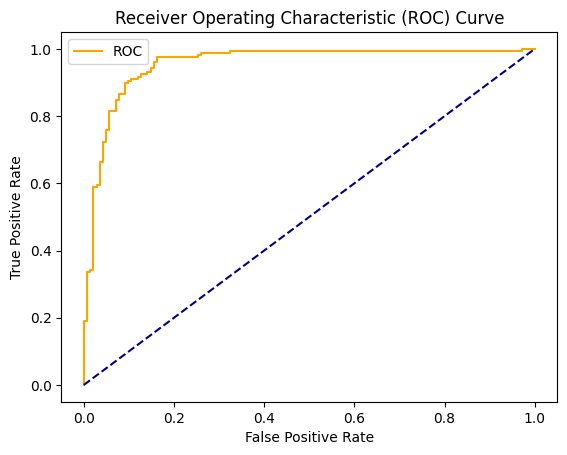

In [31]:
plot_roc_curve(fpr, tpr)